# Detecting Cancer in the CAMELYON16 dataset

## Train the Pretrained InceptionV3 Model on single-scale Data Extracted from Level 2

In this notebook, I [fine tuned](https://www.tensorflow.org/tutorials/images/transfer_learning) the pretrained InceptionV3 model in the previous experiment. For the previous experiment, see *1.1 single-scale Pretrain Level 2.ipynb* for more information. Almost all the parts are the same as the last notebook except for the Import pretrained model part, where I add codes to unfreeze top layers in the imported Inception model. By fine tuning the model, its performance on the validation set is greatly improved, especially for the validation precision.

Data is stored by slide and label. Each image is of size `299*299` (a patch extracted from the original slide by a sliding window of size 128). See *1.0 Preprocessing (single-scale).ipynb* for more details. 


The model is trained on patches at level 2. I reorganized the data folder to get patches merely from level 2. Train, validation and test data is arbitrarily separated because of the small amount of slide data. The first 13 slides is assigned to training set, and next 4 to validation and last 4 to test set. In that case, we make sure that there is no information leak between train, validation and test.

To solve the problem of having small amount of data, I applied several data augmentation method including rotation, flip, changing saturation, hue, contrast and brightness. And I also randomly sample from the data to deal with imbalanced dataset.

The model is trained on GPU offered by [Google Colab](https://colab.research.google.com) and each epoch is saved on the google drive in case of any system break down. Model weights that achieves highest validation AUC is used to evaluate on the validation and test data.

At the end of the notebook, I showed three examples of prediction on the test slides. To make inference, I implemented similar method as on the train set, by sliding a window across the slide and predict for each patch. After that, a heatmap on the slide is generated where patches that predicte positive is marked red.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import random
import pathlib, shutil
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive
import keras
import sklearn
from sklearn.metrics import roc_curve, confusion_matrix, plot_confusion_matrix
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Log in to the google cloud account. This is for saving generated data not downloading. You can log in to your own account if needed
from google.colab import auth
auth.authenticate_user()
project_id = 'storied-smile-311319'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://augmented_patches/
gs://hw4_xh2465/
gs://slices-xh2465/
gs://slides_xh2465/


In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


## Preprocessing

### Download Data

### Separate train, validation and test

The following list records number of all the slides in the data [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 21 tumor slide samples in the data.

In [ ]:
numbers = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', 
          '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']

Separate train, validation and test data. The first 13 slides is assigned to the train set, and next 4 to validation and last 4 to test set. In that case, we make sure that there is no information leak between train, validation and test.

In [ ]:
train_slides = numbers[:13]
val_slides = numbers[13:17]
test_slides = numbers[17:]

In [ ]:
# read region from the slide.
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# detect gray region
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

### Download and unzip data

In [ ]:
# download the data from given url to target path if there is no previous file exists.
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
colab_root = "/content/"

In [ ]:
file_dir = os.path.join(colab_root, "data_from2.zip")
images_folder = os.path.join(colab_root, 'data_from2/')
download_if_missing('https://storage.googleapis.com/slides_xh2465/data_from2.zip',
                    file_dir,
                    extract=False)

9529335808/9529328184 [==============================] - 122s 0us/step


'/content/data_from2.zip'

In [ ]:
!unzip -q $file_dir -d $images_folder

In [ ]:
data_root = '/content/data_from2/content/data/'

In [ ]:
# The size of data
!du -sh $data_root

11G	/content/data_from2/content/data/


### Prepare train, test, validation data

Because our dataset contains all patches from 2 to the lowest zoom level, it should be reorganized. Below is the code to copy patches from given levels to a new directory.

In [ ]:
def get_images_from_level(num_slides, levels, dir_name):
    tumor_dir = pathlib.Path(dir_name + '/tumor/') # path of tumor data
    normal_dir = pathlib.Path(dir_name + '/normal/') # path of normal data
    if os.path.exists(tumor_dir): # Clear the existing test directory
        shutil.rmtree(tumor_dir, ignore_errors=False)
    os.makedirs(tumor_dir)
    if os.path.exists(normal_dir): # Clear the existing test directory
        shutil.rmtree(normal_dir, ignore_errors=False)
    os.makedirs(normal_dir)
    # Copy patches to the new folders
    for slide in num_slides:
        for level in levels:
            for image in pathlib.Path(data_root + '/tumor_' + slide + '/normal/' + str(level)).glob('*'):
                shutil.copy(image, normal_dir)
            for image in pathlib.Path(data_root + '/tumor_' + slide + '/tumor/' + str(level)).glob('*'):
                shutil.copy(image, tumor_dir)

In [ ]:
get_images_from_level(train_slides, [2], '/content/train')

In [ ]:
get_images_from_level(val_slides, [2], '/content/val')

In [ ]:
get_images_from_level(test_slides, [2], '/content/test')

### Check class balance

In [ ]:
print('There are ', len(list(pathlib.Path('/content/train/normal').glob('*'))), ' normal patches in training set.')
print('There are ', len(list(pathlib.Path('/content/train/tumor').glob('*'))), ' tumor patches in training set.')
print('There are ', len(list(pathlib.Path('/content/val/normal').glob('*'))), ' normal patches in validation set.')
print('There are ', len(list(pathlib.Path('/content/val/tumor').glob('*'))), ' normal patches in validation set.')
print('There are ', len(list(pathlib.Path('/content/test/normal').glob('*'))), ' normal patches in test set.')
print('There are ', len(list(pathlib.Path('/content/test/tumor').glob('*'))), ' normal patches in test set.')

There are  73357  normal patches in training set.
There are  2844  tumor patches in training set.
There are  32160  normal patches in validation set.
There are  5090  normal patches in validation set.
There are  42014  normal patches in test set.
There are  5680  normal patches in test set.


Looking at the number of data point in each class, we can see the data is greatly imbalanced. There are less than 5 percent of tumor patches in the train set.

### Display few examples 

Plot few train patches from normal and tumor class respectively

In [ ]:
def random_display(file_dir, n, print_tensor=False):
    for i in range(n):
        # choose one iamge file randomly
        file_path = random.choice(list(pathlib.Path(file_dir).glob('*')))
        img = tf.io.read_file(str(file_path))  # read
        img = tf.image.decode_jpeg(img, channels=3)  # decode
        plt.imshow(img) # plot the image
        plt.show()
        if print_tensor:
            print(img)
        print()

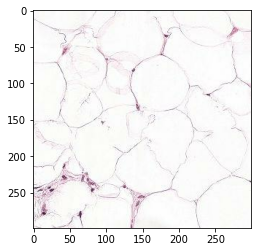

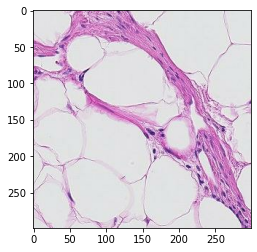

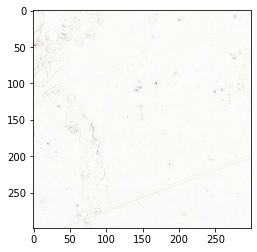

In [ ]:
random_display('/content/train/normal', 3)

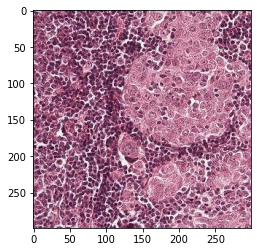

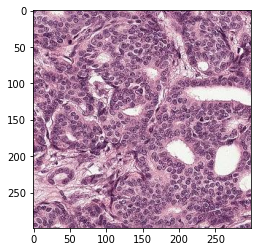

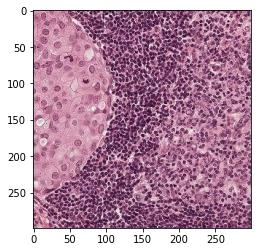

In [ ]:
random_display('/content/train/tumor', 3)

### Augment data

Imbalance data would reduce model accuracy because the model has less chance to train on the rare class. To handle this problem, I used data augmentation and randomly sample from the original data by picking 5000 normal and tumor patches respectively. 5000 normal and tumor patches are passed through a data augmentation pipeline to obtain altered data. The latter is combined with raw 5000 + 5000 data. Thus we get 20000 patches to train (10000 augmented balanced data and 10000 their original counterparts).

In [ ]:
train_dir = '/content/train/'
val_dir = '/content/val/'
test_dir = '/content/test/'

In [ ]:
IMG_SIZE = 299
BATCH_SIZE = 32

In [ ]:
def create_dir(dir):
    if os.path.exists(dir): # Clear the existing test directory
        shutil.rmtree(dir, ignore_errors=False)
    os.makedirs(dir)

In [ ]:
# directory for the sampled balanced data
train_sampled_tumor_dir = '/content/sampled_train/tumor/'
train_sampled_normal_dir = '/content/sampled_train/normal/'
# directory for the augmented balanced data
train_augmented_tumor_dir = '/content/augmented_train/tumor/'
train_augmented_normal_dir = '/content/augmented_train/normal/'

create_dir(train_sampled_tumor_dir)
create_dir(train_sampled_normal_dir)
create_dir(train_augmented_tumor_dir)
create_dir(train_augmented_normal_dir)

In [ ]:
label_names = ['normal', 'tumor']
train_tumor_datagen = ImageDataGenerator(rescale=1./255) 
train_normal_datagen = ImageDataGenerator(rescale=1./255)
# generate training data from training data directory
train_tumor_generator = train_tumor_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # adjust the image to target size
        batch_size=1,
        classes=['tumor'],
        save_to_dir=train_sampled_tumor_dir, # save the generated image to given directory
        save_format='jpg',
        save_prefix='sampled')
train_normal_generator = train_normal_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # adjust the image to target size
        batch_size=1,
        classes=['normal'],
        save_to_dir=train_sampled_normal_dir, # save the generated image to given directory
        save_format='jpg',
        save_prefix='sampled')

Found 2844 images belonging to 1 classes.
Found 73357 images belonging to 1 classes.


In [ ]:
# pass a image and randomly apply rotation, flip on it.
# Randomly adjust brightness, hue,  saturation and contrast 
# save the image to target directory
def generate_images(img, dir):
    i = random.randint(0, 3)
    img = tf.image.rot90(img, i)
    j = random.randint(0, 1)  
    if j == 1:
        img = tf.image.flip_left_right(img)
    for k in range(2):
        if k == 1:
            seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
            img = tf.image.stateless_random_brightness(img, max_delta=64./255, seed=seed)
            seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
            img = tf.image.stateless_random_hue(img, max_delta=0.04, seed=seed)
            seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
            img = tf.image.stateless_random_saturation(img, lower=0.75, upper=1.25, seed=seed)
            seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
            img = tf.image.stateless_random_contrast(img, lower=0.25, upper=1.75, seed=seed)
        tf.keras.preprocessing.image.save_img(dir+str(count)+'_'+str(i)+str(j)+str(k)+'.jpg', 
                            img.numpy(),
                            data_format='channels_last')

In [ ]:
num_data = 5000
count = 0
# train_tumor_generator and train_normal_generator randomly pick one tumor/normal image
for data_batch, labels_batch in train_tumor_generator:
    count += 1
    # randomly adjust the color of image
    generate_images(data_batch[0], train_augmented_tumor_dir)
    if count >= num_data:
        break
count = 0
for data_batch, labels_batch in train_normal_generator:
    count += 1
    # randomly adjust the color of image
    generate_images(data_batch[0], train_augmented_normal_dir)
    if count >= num_data:
        break

In [ ]:
print(len(list(pathlib.Path(train_augmented_tumor_dir).glob('*'))), ' augmented tumor images.')
print(len(list(pathlib.Path(train_augmented_normal_dir).glob('*'))), ' augmented normal images.')

10000  augmented tumor images.
10000  augmented normal images.


# Train Model

### Create data batch generator

Generate training data from the augmented folder. There are 10000(normal) + 10000(tumor) patches. 

Generate validation data from the validation folder.

In [ ]:
label_names = ['normal', 'tumor']
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
# generate training data from training data directory
train_generator = train_datagen.flow_from_directory(
        '/content/augmented_train/',
        target_size=(IMG_SIZE, IMG_SIZE), # adjust the image to target size
        batch_size=BATCH_SIZE,
        classes=label_names,
        class_mode='binary') 
# generate validation data from validation data directory
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=label_names,
    class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 20000 images belonging to 2 classes.
Found 37250 images belonging to 2 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


### Import pretrained model

Import InceptionV3 model pretrained on the ImageNet dataset. The parameters in the Inception model is pretrained on the ImageNet dataset. Different from previous notebook, here I only freeze the first 100 layers in the model.

In [ ]:
# import InceptionV3 model
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
# Add last layer and the classification dense layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 19,628,417
Non-trainable params: 2,176,416
_________________________________________________________________


### Define metrics

Although the train data is balanced, our validation and test data are imlalanced and if we only focus on accuracy, it would look nice for any model (always predicting negative gives above 95% accuracy). For imbalanced data, we need different metrics to evaluate model performance.



*   true positives (tp): number of tumor patches correctly classified

*   false positives (fp): number of normal patches classified as tumor

*   true negatives (tn): number of normal patches correctly classified

*   false negatives (fn): number of tumor patches classified as normal

*   accuracy: total rate of correctly classified patches = tn + tp / (p + n)

*   precision: fraction of correctly classified tumor patches among all patches that is classified as tumor

*   recall: fraction of correctly classified tumor patches among all tumor patches

*   auc: Area Under the Curv, measure of the ability of a classifier to distinguish between two classes

*   prc: precision-recall curve








In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Because our labels are one-hot encoded, we need to use categorical_crossentropy
              metrics=METRICS)

### Create checkpoints

In [ ]:
.checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "project")
checkpoint_dir = os.path.join(checkpoint_dir, "single scale Fine Tune")
# Used for formatting
checkpoint = ModelCheckpoint(filepath=pathlib.Path(str(checkpoint_dir)+'/model.{epoch:02d}.h5'))

In [ ]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/project/Single Scale Fine Tune
Creating a checkpoints directory


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Save augmented data

Before training, I uploaded the augmented data to the Google Cloud Storage in case of future need.

In [ ]:
shutil.make_archive('augmented_train', 'zip', pathlib.Path('/content/augmented_train/'))
shutil.make_archive('test', 'zip', pathlib.Path('/content/test/'))
shutil.make_archive('train', 'zip', pathlib.Path('/content/train/'))
shutil.make_archive('val', 'zip', pathlib.Path('/content/val/'))

'/content/val.zip'

In [ ]:
bucket_name = 'augmented_patches'
!gsutil -m cp -r /content/augmented_train.zip gs://{bucket_name}/Balanced_Transfer_Learning_Level2
!gsutil -m cp -r /content/test.zip gs://{bucket_name}/Balanced_Transfer_Learning_Level2
!gsutil -m cp -r /content/train.zip gs://{bucket_name}/Balanced_Transfer_Learning_Level2
!gsutil -m cp -r /content/val.zip gs://{bucket_name}/Balanced_Transfer_Learning_Level2

Copying file:///content/augmented_train.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1/1 files][496.8 MiB/496.8 MiB] 100% Done                                    
Operation completed over 1 objects/496.8 MiB.                                    
Copying file:///content/test.zip [Content-Type=application/zip]...
==> NOTE: You ar

### Train model

Now everything is built up, train the model for 20 epoches and save weights at each epoch to the cloud drive.

In [ ]:
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=20, 
                    callbacks=[checkpoint]
                    )

Epoch 1/20
625/625 [==============================] - 204s 316ms/step - loss: 0.1493 - tp: 4784.3978 - fp: 164.9553 - tn: 4824.5655 - fn: 258.0304 - accuracy: 0.9443 - precision: 0.9515 - recall: 0.9396 - auc: 0.9831 - prc: 0.9822 - val_loss: 0.0643 - val_tp: 4413.0000 - val_fp: 187.0000 - val_tn: 31973.0000 - val_fn: 677.0000 - val_accuracy: 0.9768 - val_precision: 0.9593 - val_recall: 0.8670 - val_auc: 0.9949 - val_prc: 0.9740
Epoch 2/20
625/625 [==============================] - 195s 312ms/step - loss: 0.0384 - tp: 4920.2700 - fp: 40.4649 - tn: 4992.9553 - fn: 78.2588 - accuracy: 0.9881 - precision: 0.9920 - recall: 0.9840 - auc: 0.9988 - prc: 0.9984 - val_loss: 0.0857 - val_tp: 4176.0000 - val_fp: 148.0000 - val_tn: 32012.0000 - val_fn: 914.0000 - val_accuracy: 0.9715 - val_precision: 0.9658 - val_recall: 0.8204 - val_auc: 0.9843 - val_prc: 0.9612
Epoch 3/20
625/625 [==============================] - 195s 312ms/step - loss: 0.0213 - tp: 5003.2891 - fp: 24.4313 - tn: 4964.6406 - fn:

### Plot metrics during the epoches

Plot the change of each metric value during epoches.

In [ ]:
def plot(history, metrics):
  
    # The history object contains results on the training and validation
    # sets for each epoch
    for metric in metrics:
        value = history.history[metric]
        val_value = history.history['val_'+metric]

        # Get the number of epochs
        epochs = range(len(value))

        plt.title('Training and validation ' + metric)
        plt.plot(epochs, value, color='blue', label='Train')
        plt.plot(epochs, val_value,  color='orange', label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

In [ ]:
metrics_name = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']

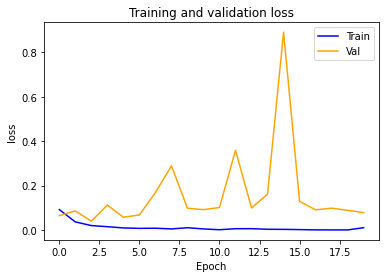

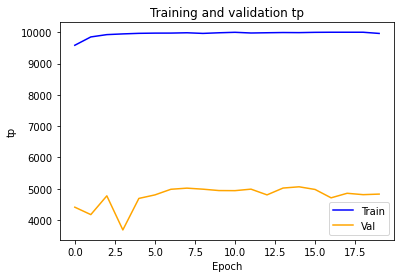

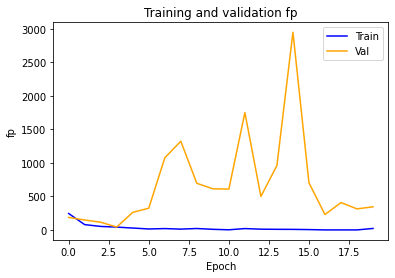

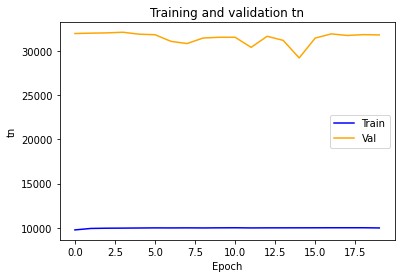

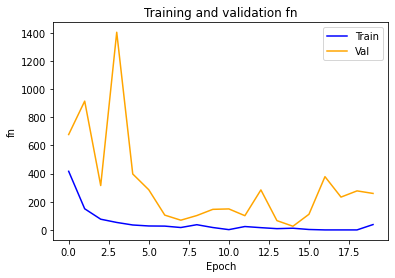

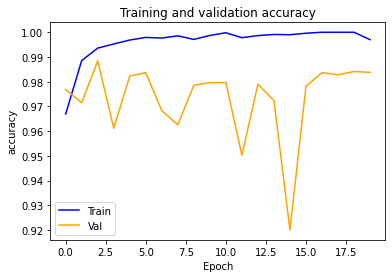

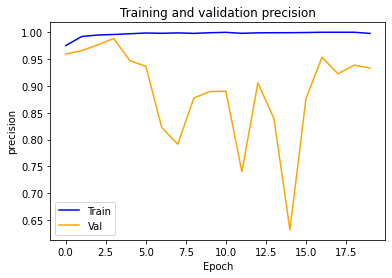

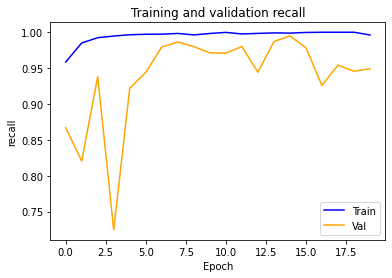

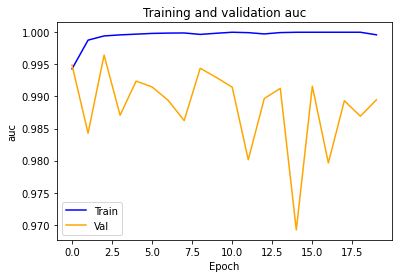

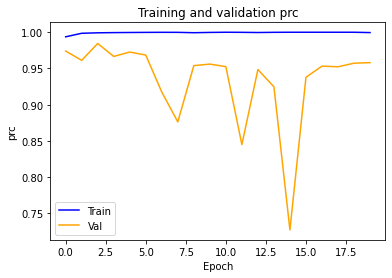

In [ ]:
plot(history, metrics_name)

### Load the best model

I found that although training metrics seem to improve during epoches, the validation metrics start to decrease after the several epoches, which is reflected by the AUC and PRC values. Thus I chose to pick the model on the third epoch which has relatively high AUC. 

Below is the code that reloads weights on the third epoch.

In [ ]:
checkpoint_dir

'/gdrive/My Drive/checkpoints/project/Single Scale Fine Tune'

In [ ]:
model.load_weights(checkpoint_dir + '/model.20.h5')

In [ ]:
model.save(checkpoint_dir + '/saved_model')

INFO:tensorflow:Assets written to: /gdrive/My Drive/checkpoints/project/Single Scale Fine Tune/saved_model/assets


## Prediction on the test set

Now we have a trained model, the next thing to do is to make predictions on the test set. 

Create a test generator.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=label_names,
    class_mode='binary',
    shuffle=False)

Found 47694 images belonging to 2 classes.


In [ ]:
# evaluate on the test set
evaluate_test = model.evaluate(test_generator)

1491/1491 [==============================] - 131s 88ms/step - loss: 0.0788 - tp: 5316.0000 - fp: 373.0000 - tn: 41641.0000 - fn: 364.0000 - accuracy: 0.9845 - precision: 0.9344 - recall: 0.9359 - auc: 0.9849 - prc: 0.9532


### Confusion Matrix

Plot confusion matrix of the model prediction on the test set

In [ ]:
predict_test = model.predict(test_generator)

In [ ]:
predict_test = predict_test.reshape(-1)
pred_bool = np.array([1 if p > 0.5 else 0 for p in predict_test])

In [ ]:
truths = test_generator.classes

In [ ]:
def plot_cm(pred, label, p=0.5):
    cm = confusion_matrix(label, pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Normal patches Detected (True Negatives): ', cm[0][0])
    print('Normal patches Incorrectly Detected (False Positives): ', cm[0][1])
    print('Cancerous patches Missed (False Negatives): ', cm[1][0])
    print('Cancerous patches Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Normal patches Detected (True Negatives):  41641
Normal patches Incorrectly Detected (False Positives):  373
Cancerous patches Missed (False Negatives):  364
Cancerous patches Detected (True Positives):  5316
Total Fraudulent Transactions:  5680


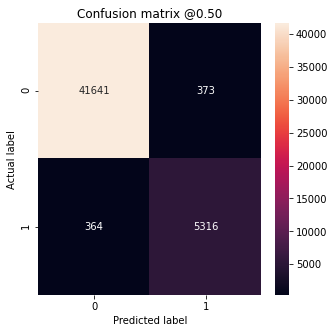

In [ ]:
plot_cm(pred_bool, truths)

### Plot ROC curve

In [ ]:
def plot_roc(pred, label):
    fpr, tpr, threshold = roc_curve(label, pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

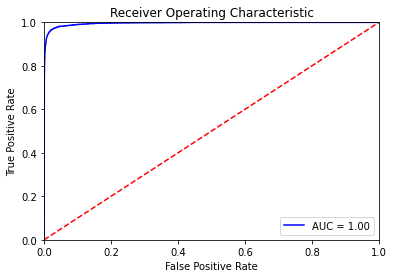

In [ ]:
plot_roc(predict_test, truths)

### Plot heatmaps

The ROC curve shows that the model is performing well on the test set. Note that we are making predictions on the patches extracted from the original slide image. Our goal is to make predictions on the slide, that is, to tell which region contains tumor cell. To show how it could find out tumor regions, I pick out three tumor slide in the test set-No.094, No.101, No.110 to make inference on the images.

To make inference, I write a function to slide a window across the image and call the model each time to make predictions. Iteration through the whole image gives me a 2d matrix which is the heatmap of model predictions.

In [ ]:
# download any slide from the Google Cloud
def download_slide(slide_name):
    data_dir = 'https://storage.googleapis.com/slices-xh2465/'
    slide_url = data_dir + slide_name + '.tif'
    mask_url = data_dir + slide_name + '_mask.tif'
    !curl -O $slide_url
    !curl -O $mask_url
    slide_path = slide_name + '.tif'
    tumor_mask_path = slide_name + '_mask.tif'
    return slide_path, tumor_mask_path

In [ ]:
# Show the slide image and its tumor mask
def diplay_whole_slide(slide, tumor_mask, level=5):
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
    mask_image = mask_image[:,:,0]
    # Overlay them. The idea is that the mask shows the region of the slide that
    # contain cancerous cells.
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(slide_image)
    plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
    plt.show()

In [ ]:
patch_size = 299
center_size = 128
stride = 128

In [ ]:
def preprocess_image(img):
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # resize
    img /= 255.0  # normalize pixels to 0,1
    return img

In [ ]:
def output_heatmap(slide, model, level, x=0, y=0, width=None, height=None):
    # if the heatmap size is not given, output the whole slide
    if width is None and height is None:
        width, height = slide.level_dimensions[level]
    # top-left coordinates of the slide window
    i, j = x, y
    downsample = 2**level
    heatmap = []
    while j <= y + height - patch_size:
        heatmap.append([])
        while i <= x + width - patch_size:
            # Get the center image
            center_image = read_slide(slide, 
                                    x=(i+(patch_size-center_size)//2+1) * downsample, 
                                    y=(j+(patch_size-center_size)//2+1) * downsample, 
                                    level=level, 
                                    width=center_size, 
                                    height=center_size)
            # If center patch is identified as background,
            # output 0
            if len(find_tissue_pixels(center_image)) == 0:
                i += stride
                heatmap[-1].append(0.0)
                continue
            # Get the context patch
            patch_image = read_slide(slide, 
                                    x=i * downsample, 
                                    y=j * downsample, 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size)
            # Normalize image
            img = preprocess_image(patch_image)
            # Predict
            batch_pred = model.predict(tf.expand_dims(img, axis=0))
            pred = batch_pred[0][0]
            heatmap[-1].append(pred)
            i += stride
        i = x
        j += stride
    return heatmap


#### Example - tumor_101

In [ ]:
slide_path, tumor_mask_path = download_slide('tumor_101')
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1392M  100 1392M    0     0  62.9M      0  0:00:22  0:00:22 --:--:-- 62.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.9M  100 43.9M    0     0  25.2M      0  0:00:01  0:00:01 --:--:-- 25.2M


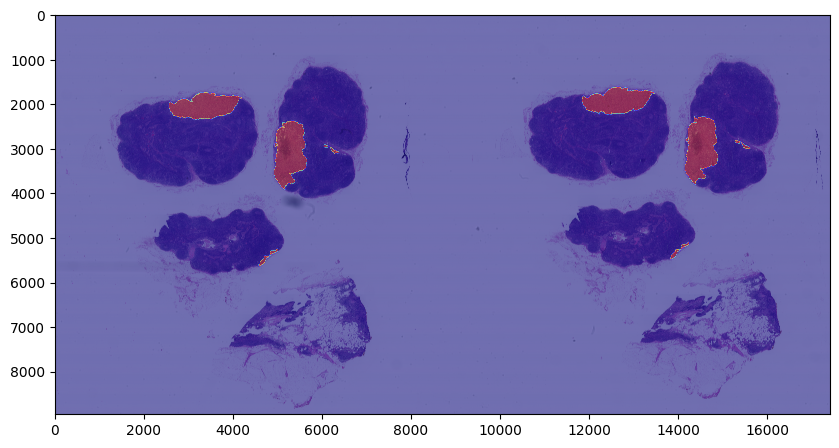

In [ ]:
diplay_whole_slide(slide, tumor_mask, level=3)

In [ ]:
x, y, width, height = 3000, 3000, 8000, 8000

In [ ]:
patch = read_slide(slide, x=x * 4, y=y * 4, level=2, width=width, height=height)

In [ ]:
region = read_slide(tumor_mask, x=x * 4, y=y * 4, level=2, width=width, height=height)[:,:,0]

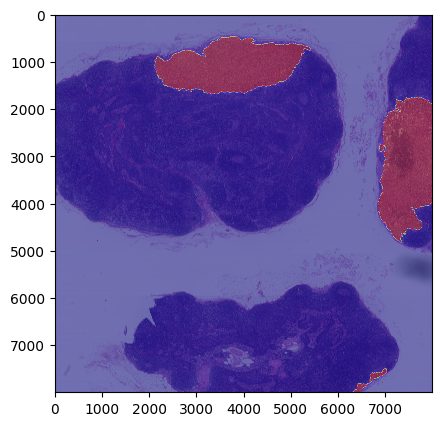

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(patch)
plt.imshow(region, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap = output_heatmap(slide, model, 2, x, y, width=width, height=height)

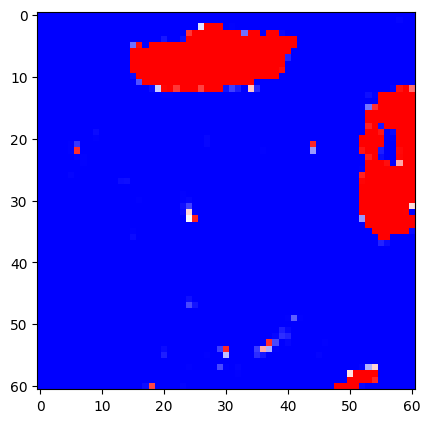

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(heatmap, cmap='bwr', vmin=0, vmax=1)
plt.show()

#### Example - tumor_110

In [ ]:
slide_path, tumor_mask_path = download_slide('tumor_110')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0  58.6M      0  0:00:24  0:00:24 --:--:-- 68.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  30.3M      0  0:00:01  0:00:01 --:--:-- 30.3M


In [ ]:
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

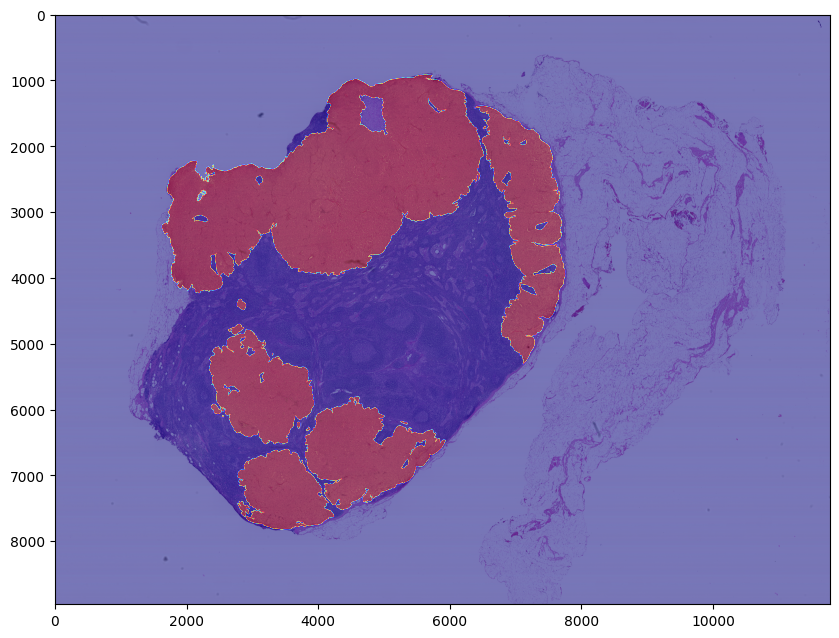

In [ ]:
diplay_whole_slide(slide, tumor_mask, level=3)

In [ ]:
x, y, width, height = 4000, 4000, 8000, 8000

In [ ]:
patch = read_slide(slide, x=x * 4, y=y * 4, level=2, width=width, height=height)

In [ ]:
region = read_slide(tumor_mask, x=x * 4, y=y * 4, level=2, width=width, height=height)[:,:,0]

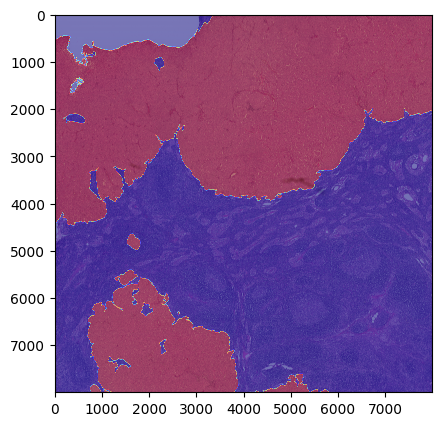

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(patch)
plt.imshow(region, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap = output_heatmap(slide, model, 2, x, y, width, height)

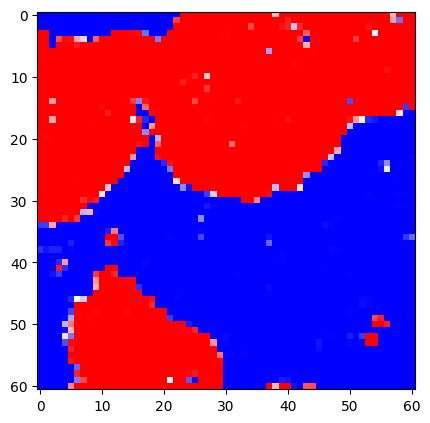

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(heatmap, cmap='bwr', vmin=0, vmax=1)
plt.show()

#### Example - tumor_094

In [ ]:
slide_path, tumor_mask_path = download_slide('tumor_094')
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1534M  100 1534M    0     0   104M      0  0:00:14  0:00:14 --:--:--  111M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.7M  100 51.7M    0     0  33.8M      0  0:00:01  0:00:01 --:--:-- 33.8M


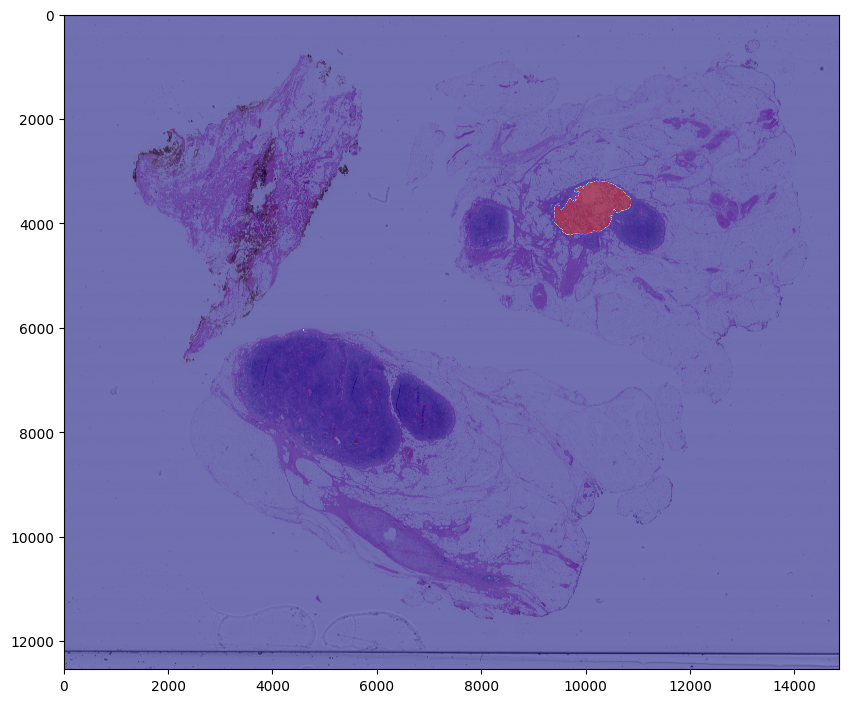

In [ ]:
diplay_whole_slide(slide, tumor_mask, level=3)

In [ ]:
x, y, width, height = 16000, 6000, 8000, 8000

In [ ]:
patch = read_slide(slide, x=x * 4, y=y * 4, level=2, width=width, height=height)

In [ ]:
region = read_slide(tumor_mask, x=x * 4, y=y * 4, level=2, width=width, height=height)[:,:,0]

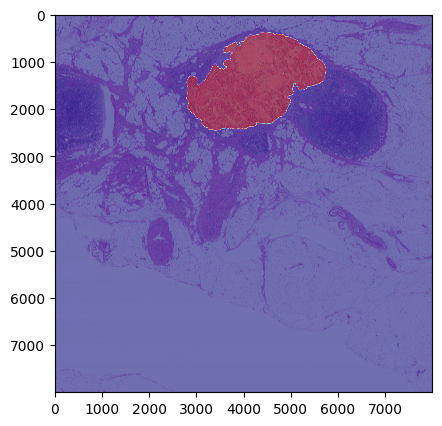

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(patch)
plt.imshow(region, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap = output_heatmap(slide, model, 2, x, y, width, height)

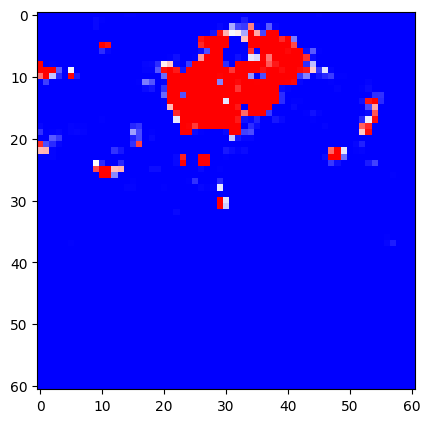

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(heatmap, cmap='bwr', vmin=0, vmax=1)
plt.show()